# Toy problem for debugging Dual Decomposition

$$
\begin{align*}
\max_{x_k,y} \quad & \sum_k f_k'y + \sum_k c_k'x_k \\
\mathrm{s.t.} \quad & A_k x_k + B_k y \leq d_k, \\
& y\in \{0,1\}.
\end{align*}
$$

$$
\begin{align*}
\max_{x_k,y_k} \quad & \sum_k f_k'y + \sum_k c_k'x_k \\
\mathrm{s.t.} \quad & A_k x_k + B_k y_k \leq d_k, \\
& \sum_k H_k y_k = 0, \\
& y_k\in \{0,1\}.
\end{align*}
$$

In [1]:
RELAX_LP = True

In [2]:
from __future__ import division
from cobra import Model
from dynamicme.optimize import Variable, Constraint
from six import iteritems
import numpy as np
import pandas as pd

### Example from
http://www.optirisk-systems.com/manuals/FortspManual.pdf

$$
\begin{align*}
\max_{x,y} \quad & \sum_k P_k \left( \sum_c p^s_c x^s_{c,k} - p^b_c x^b_{c,k}  - \sum_c c_c a_c \right)\\
\mathrm{s.t.} \quad & \sum_c a_c \leq A \\
& Y_{c,k}  a_c - x^s_{c,k} + x^b_{c,k} \geq R_c \\
& x^s_{\mathrm{beet},k} \leq Q(\mathrm{beet}) \\
& x^s_{\mathrm{beet},c} + s^x_k \leq Y_{\mathrm{beet},k} a_\mathrm{beet}
\end{align*}
$$

In [3]:
from dynamicme.decomposition import LagrangeMaster, LagrangeSubmodel

In [4]:
#------------------------------------------------------------
# Data
crops = ['wheat','corn','beet']
total_area = 500.  # Total acres
prob_dict = {'below':1./3, 'average':1./3, 'above':1./3}
# Yields (tons/acre) over scenarios
yield_dict = {}
yield_dict['below'] = {'wheat':2., 'corn':2.4, 'beet':16.}
yield_dict['average'] = {'wheat':2.5, 'corn':3., 'beet':20.}
yield_dict['above'] = {'wheat':3., 'corn':3.6, 'beet':24.}
# Planting costs
plantcost_dict={'wheat':150, 'corn':230, 'beet':260}   # $/ton
sellprice_dict = {'wheat':170, 'corn':150, 'beet':36}  # $/ton
excess_sell_price = 10    # beet sell price ($/ton) when quota exceeded
beet_quota = 6000   # tons
buyprice_dict = {'wheat':238, 'corn':210, 'beet':100}  # $/ton
req_dict = {'wheat':200., 'corn':240., 'beet':0.} # tons required to feed cattle
#------------------------------------------------------------
# Area is complicating (first-stage) variable

In [5]:
# Create subproblems
UB = 1e4
sub_dict = {}
for scen,yields in iteritems(yield_dict):
    # Each subproblem gets its own copy of first-stage variables
    area_dict = {c:Variable('area_%s'%c, lower_bound=0., upper_bound=1e6,
        objective_coefficient=prob_dict[scen]*plantcost_dict[c]) for c in crops}
    for y in area_dict.values():
        y.variable_kind = 'integer'
    mdl = Model('sub')
    mdl.add_reactions(area_dict.values())
    # Global constraint: sum_a <= Area
    cons_area = Constraint('total_area')
    cons_area._bound = total_area
    cons_area._constraint_sense = 'L'
    mdl.add_metabolites(cons_area)
    for y in area_dict.values():
        y.add_metabolites({cons_area:1.}, combine=False)

    # MAX sell price
    x_excess = Variable('sell_excess_beet', lower_bound=0., upper_bound=UB)
    x_excess.objective_coefficient = -prob_dict[scen]*excess_sell_price    
    mdl.add_reaction(x_excess)
    
    for c in crops:
        ### Scenario variables x: tons sold, bought, excess sold per scenario
        x_sell = Variable('sell_%s'%(c), lower_bound=0., upper_bound=UB)
        x_buy  =  Variable('buy_%s'%(c), lower_bound=0., upper_bound=UB)
        mdl.add_reactions([x_sell,x_buy])        
        x_sell.objective_coefficient = -prob_dict[scen]*sellprice_dict[c]
        x_buy.objective_coefficient = prob_dict[scen]*buyprice_dict[c]
        
        ### Scenario constraint: Y_ck*ac - xs_ck + xb_ck >= Req_c        
        cons = Constraint('required_%s'%c)
        cons._bound = req_dict[c]
        cons._constraint_sense = 'G'        
        mdl.add_metabolites(cons)
        area = area_dict[c]
        area.add_metabolites({cons:yield_dict[scen][c]})
        x_sell.add_metabolites({cons:-1.})
        x_buy.add_metabolites({cons:1.})
        
        ### Beet quota
        if c=='beet':
            x_sell.upper_bound = beet_quota
            # xs_beet,k + xexcess_k <= Yield_beet,k * area_beet
            cons_beet = Constraint('beet_balance')
            cons_beet._bound = 0.
            cons_beet._constraint_sense = 'L'
            x_sell.add_metabolites({cons_beet:1.})
            x_excess.add_metabolites({cons_beet:1.})
            area_dict[c].add_metabolites({cons_beet:-yield_dict[scen][c]})
    
    sub = LagrangeSubmodel(mdl, scen)
    sub_dict[scen] = sub

In [6]:
master = LagrangeMaster(mdl)
master._INF = 1e7
master.add_submodels(sub_dict)
master._z.LB = -master._INF
master._z.UB = master._INF
master.model.update()

In [7]:
obj = master.model.getObjective()
obj

<gurobi.QuadExpr: z + [ -0.5 u_00 ^ 2 + -0.5 u_01 ^ 2 + -0.5 u_02 ^ 2 + -0.5 u_10 ^ 2 + -0.5 u_11 ^ 2 + -0.5 u_12 ^ 2 ]>

In [8]:
for v in master.model.getVars():
    print(v.VarName, v.LB, v.UB)

('z', -10000000.0, 10000000.0)
('tk_below', -10000000.0, 10000000.0)
('tk_average', -10000000.0, 10000000.0)
('tk_above', -10000000.0, 10000000.0)
('u_00', -10000000.0, 10000000.0)
('u_01', -10000000.0, 10000000.0)
('u_02', -10000000.0, 10000000.0)
('u_10', -10000000.0, 10000000.0)
('u_11', -10000000.0, 10000000.0)
('u_12', -10000000.0, 10000000.0)


In [9]:
master.penaltytol

1e-06

In [10]:
master.model.Params.Presolve = 0
# master.model.Params.ScaleFlag = 2
# master.model.Params.NumericFocus = 3
master.model.Params.BarHomogeneous = 1

# master.model.Params.Method = 0  # primal simplex
# master.model.Params.Method = 1  # dual simplex
master.model.Params.Method = 2  # barrier

master.model.Params.OutputFlag=0
master.max_iter = 20
master.print_iter=1
master.verbosity = 2

master.delta_mult = 0.5   #0.1
master.delta_min  = 0.5 #1e-10 #0
master.gaptol = 1e-4 # 0.001 #0.02

feasible_methods = ['heuristic', 'enumerate']
alt_method = 'pool'
max_alt = 10

if RELAX_LP:
    sol_master = master.solve_relaxed(feasible_methods=None)
    df_phase1 = pd.DataFrame(master.log_rows)

sol_master = master.optimize(feasible_methods=feasible_methods, max_alt=max_alt, alt_method=alt_method) 
df_phase2 = pd.DataFrame(master.log_rows)

    Iter                    UB                    LB       gap relgap(%)   penalty                       Time(s)
  ------   -------------------   -------------------  -------- ---------  -------- -----------------------------
               Best   Feasible        Sub       Best                                   total    master       sub
       0      1e+07     1e+100 -1.154e+05 -1.154e+05 1.012e+07     101.2         0  0.003171  0.000378  0.001569
       1 -4.869e+04     1e+100 -3.337e+05 -1.154e+05 6.671e+04       137  3.34e+04  0.004642  0.000267  0.000942
       2 -9.971e+04     1e+100  -1.89e+05 -1.154e+05 1.569e+04     15.74  6.31e+03  0.006098  0.000381  0.000916
       3 -1.067e+05     1e+100 -1.138e+05 -1.138e+05      7138      6.69  1.54e+03  0.007591  0.000355  0.000896
pred_ascent=6698.88888874. Updating D_prox from -115405.555556 to -108706.666668.
       4 -1.087e+05     1e+100 -1.087e+05 -1.087e+05         0         0  1.99e+03  0.009757  0.000332  0.000890
       5 -1.07

for sub_ind,sub in iteritems(sub_dict):
    sub.optimize()
    yk = [y.X for y in sub._ys]
    print("%s: %s"%(sub_ind, yk))    

for cons in sub.model.getConstrs():
    print(sub.model.getRow(cons),cons.Sense,cons.RHS)

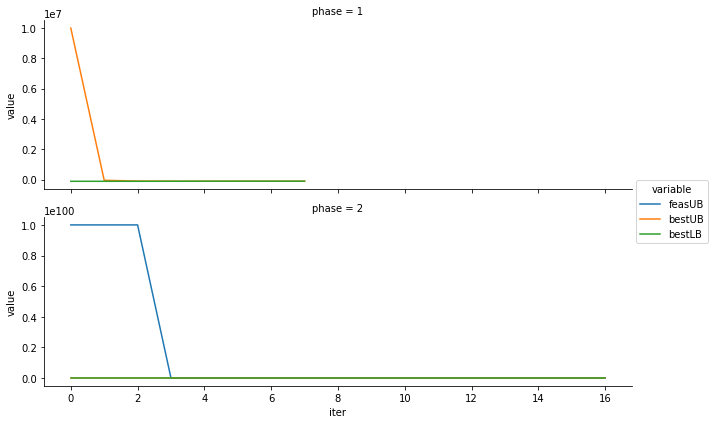

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

xcol = 'iter'
df_phase1.loc[:,'phase'] = 1
df_phase1.loc[:,'feasUB'] = np.nan
df_phase2.loc[:,'phase'] = 2
dsplot = pd.concat([df_phase1, df_phase2])
dsplot = dsplot[[xcol,'feasUB','bestUB','bestLB','phase']]
dsplot = dsplot.melt(id_vars=[xcol,'phase'])
# dsplot.loc[ dsplot.value>1e1, 'value'] = np.nan
# dsplot.loc[ dsplot.value<-1e1, 'value'] = np.nan

g = sns.FacetGrid(dsplot, hue='variable', size=3, aspect=3, row='phase', sharey=False)
g.map(plt.plot, xcol,'value')
g.add_legend()

## Check answer: should be 
- {'wheat':170, 'corn':80, 'beet':250}
- objval = (-)108390

## Check that the optimal feasible solution works

In [12]:
sol_master

{'area_beet': 250.0, 'area_corn': 80.0, 'area_wheat': 170.0}

In [13]:
ybest = master.yopt

obj_dict, feas_dict, stat_dict = master.check_feasible(ybest)

print('Scenario objectives: %s' % obj_dict)
print('Total expected objective: %s' % sum(obj_dict.values()))

Scenario objectives: {'below': -15199.999999528125, 'average': -30328.888890184462, 'above': -62861.11111028741}
Total expected objective: -108390.0


yenum,enum_dict = master.enum_alt_opt()
enum_dict

ycheck = sub.yopt
master.check_feasible(ycheck)

sub.model.Params.PoolSearchMode=2
sub.model.Params.PoolSolutions=100
sub.optimize()
sub.model.SolCount

for sub_ind,sub in iteritems(sub_dict):
    sub.model.Params.PoolSearchMode=2
    sub.model.Params.PoolSolutions=100
    sub.optimize()
    print(sub_ind)
    print('SolCount: %s' % sub.model.SolCount)
    print('Best obj: %s' % sub.model.ObjVal)
    print('PoolObjBound; %s' % sub.model.PoolObjBound)
    K = 2
    pool_objs = []
    for k in range(sub.model.SolCount):
        sub.model.Params.SolutionNumber=k
        pool_objs.append(sub.model.PoolObjVal)
        if k < K:            
            print('Solution %d (Obj=%s): %s' % (k, sub.model.PoolObjVal,sub.model.Xn))
    n_alt = sum(abs(np.array(pool_objs) - sub.model.ObjVal) / (1e-10 + abs(sub.model.ObjVal)) < master.gaptol)
    print('%d solutions have obj=%s' % (n_alt, sub.model.ObjVal))

sub.model.Params.SolutionNumber

{v.VarName:v.Xn for v in sub.model.getVars()}

# Duality gap = 0 under various Constraint qualifications
(Does Slater's condition hold here: $\exists x^* \in \mathrm{relint}(D)$?)

# Duality gap = 0 without satisfying non-anticipativity constraints?

# Duality gap = 0 still doesn't mean solution to Lagrange dual is primal feasible

# Sometimes if duality gap = 0, can construct primal feasible from dual
http://eceweb.ucsd.edu/~gert/ECE273/hindiTutorial2.pdf

In [14]:
print(master._z.X)
master.model.getObjective()

-108390.0


<gurobi.QuadExpr: -2321.14814862 + z + -22.4444444505 u_00 + 14.0555555653 u_01 + 8.38888888434 u_02 + 31.7777777771 u_10 + -11.7222222202 u_11 + -20.0555555578 u_12 + [ -0.25 u_00 ^ 2 + -0.25 u_01 ^ 2 + -0.25 u_02 ^ 2 + -0.25 u_10 ^ 2 + -0.25 u_11 ^ 2 + -0.25 u_12 ^ 2 ]>

In [15]:
for sub_ind,sub in iteritems(sub_dict):
    print('%s'%sub_ind)    
    #print([(x.VarName, x.Obj, x.X) for x in sub._ys])
    print([(k,v) for k,v in iteritems(sub.x_dict)])
    print('-'*40)

below
[('buy_wheat', 0.0), ('area_beet', 250.0), ('area_corn', 80.0), ('sell_wheat', 140.0), ('buy_corn', 48.0), ('sell_excess_beet', 0.0), ('sell_corn', 0.0), ('sell_beet', 4000.0), ('buy_beet', 0.0), ('area_wheat', 170.0)]
----------------------------------------
average
[('buy_wheat', 0.0), ('area_beet', 250.0), ('area_corn', 80.0), ('sell_wheat', 225.0), ('buy_corn', 0.0), ('sell_excess_beet', 0.0), ('sell_corn', 0.0), ('sell_beet', 5000.0), ('buy_beet', 0.0), ('area_wheat', 170.0)]
----------------------------------------
above
[('buy_wheat', 0.0), ('area_beet', 250.0), ('area_corn', 80.0), ('sell_wheat', 310.0), ('buy_corn', 0.0), ('sell_excess_beet', 0.0), ('sell_corn', 48.0), ('sell_beet', 6000.0), ('buy_beet', 0.0), ('area_wheat', 170.0)]
----------------------------------------


In [16]:
for sub_ind,sub in iteritems(sub_dict):
    print('%s'%sub_ind)
    print(sub.model.getObjective())
    print(sub.x_dict)
    print('-'*40)

below
<gurobi.LinExpr: 105.333333338 area_beet + 81.333333329 area_corn + 26.6666666642 area_wheat + -3.33333333333 sell_excess_beet + -56.6666666667 sell_wheat + 79.3333333333 buy_wheat + -50.0 sell_corn + 70.0 buy_corn + -12.0 sell_beet + 33.3333333333 buy_beet>
{'buy_wheat': 0.0, 'area_beet': 250.0, 'area_corn': 80.0, 'sell_wheat': 140.0, 'buy_corn': 48.0, 'sell_excess_beet': 0.0, 'sell_corn': 0.0, 'sell_beet': 4000.0, 'buy_beet': 0.0, 'area_wheat': 170.0}
----------------------------------------
average
<gurobi.LinExpr: 131.555555551 area_beet + 48.5555555659 area_corn + 33.2222222164 area_wheat + -3.33333333333 sell_excess_beet + -56.6666666667 sell_wheat + 79.3333333333 buy_wheat + -50.0 sell_corn + 70.0 buy_corn + -12.0 sell_beet + 33.3333333333 buy_beet>
{'buy_wheat': 0.0, 'area_beet': 250.0, 'area_corn': 80.0, 'sell_wheat': 225.0, 'buy_corn': 0.0, 'sell_excess_beet': 0.0, 'sell_corn': 0.0, 'sell_beet': 5000.0, 'buy_beet': 0.0, 'area_wheat': 170.0}
-----------------------------

In [17]:
### Bound
master._z

<gurobi.Var z (value -108390.0)>

$$
\begin{align*}
\max_{x,y} \quad & \sum_k P_k \left( \sum_c p^s_c x^s_{c,k} - p^b_c x^b_{c,k}  - \sum_c c_c a_c \right)\\
\mathrm{s.t.} \quad & \sum_c a_c \leq A \\
& Y_{c,k}  a_c - x^s_{c,k} + x^b_{c,k} \geq R_c \\
& x^s_{\mathrm{beet},k} \leq Q(\mathrm{beet}) \\
& x^s_{\mathrm{beet},c} + s^x_k \leq Y_{\mathrm{beet},k} a_\mathrm{beet}
\end{align*}
$$

In [18]:
sub.model.getObjective()

<gurobi.LinExpr: 23.1111111107 area_beet + 100.111111105 area_corn + 90.1111111194 area_wheat + -3.33333333333 sell_excess_beet + -56.6666666667 sell_wheat + 79.3333333333 buy_wheat + -50.0 sell_corn + 70.0 buy_corn + -12.0 sell_beet + 33.3333333333 buy_beet>

In [19]:
# Actual
objval = 0.
for scen,sub in iteritems(master.sub_dict):
    objval += sub.ObjVal

objval

-108390.0

In [20]:
x_dict = {}
for scen,sub in iteritems(master.sub_dict):
    x_dict[scen] = sub.x_dict

In [21]:
x_dict

{'above': {'area_beet': 250.0,
  'area_corn': 80.0,
  'area_wheat': 170.0,
  'buy_beet': 0.0,
  'buy_corn': 0.0,
  'buy_wheat': 0.0,
  'sell_beet': 6000.0,
  'sell_corn': 48.0,
  'sell_excess_beet': 0.0,
  'sell_wheat': 310.0},
 'average': {'area_beet': 250.0,
  'area_corn': 80.0,
  'area_wheat': 170.0,
  'buy_beet': 0.0,
  'buy_corn': 0.0,
  'buy_wheat': 0.0,
  'sell_beet': 5000.0,
  'sell_corn': 0.0,
  'sell_excess_beet': 0.0,
  'sell_wheat': 225.0},
 'below': {'area_beet': 250.0,
  'area_corn': 80.0,
  'area_wheat': 170.0,
  'buy_beet': 0.0,
  'buy_corn': 48.0,
  'buy_wheat': 0.0,
  'sell_beet': 4000.0,
  'sell_corn': 0.0,
  'sell_excess_beet': 0.0,
  'sell_wheat': 140.0}}

In [22]:
Hys = []
sub_objs = []
for sub_ind,sub in iteritems(sub_dict):
    yk = np.array([sub.x_dict[x.VarName] for x in sub._ys])
    Hyk = sub._H*yk
    Hys.append(Hyk)    
    sub_objs.append(sub.ObjVal)
    print('Scenario: %s'%sub_ind)
    print('yk = %s'%[(k,v) for k,v in iteritems(sub.x_dict)])
    print('Hk*yk =%s' % Hyk)
    
print("\nsum_k Hk*yk=")
print(sum(Hys))
print("sum sum Hk*yk=%s"%sum(sum(Hys)))
print("\n u = %s" % master.uopt)

Scenario: below
yk = [('buy_wheat', 0.0), ('area_beet', 250.0), ('area_corn', 80.0), ('sell_wheat', 140.0), ('buy_corn', 48.0), ('sell_excess_beet', 0.0), ('sell_corn', 0.0), ('sell_beet', 4000.0), ('buy_beet', 0.0), ('area_wheat', 170.0)]
Hk*yk =[250.  80. 170. 250.  80. 170.]
Scenario: average
yk = [('buy_wheat', 0.0), ('area_beet', 250.0), ('area_corn', 80.0), ('sell_wheat', 225.0), ('buy_corn', 0.0), ('sell_excess_beet', 0.0), ('sell_corn', 0.0), ('sell_beet', 5000.0), ('buy_beet', 0.0), ('area_wheat', 170.0)]
Hk*yk =[-250.  -80. -170.    0.    0.    0.]
Scenario: above
yk = [('buy_wheat', 0.0), ('area_beet', 250.0), ('area_corn', 80.0), ('sell_wheat', 310.0), ('buy_corn', 0.0), ('sell_excess_beet', 0.0), ('sell_corn', 48.0), ('sell_beet', 6000.0), ('buy_beet', 0.0), ('area_wheat', 170.0)]
Hk*yk =[   0.    0.    0. -250.  -80. -170.]

sum_k Hk*yk=
[0. 0. 0. 0. 0. 0.]
sum sum Hk*yk=0.0

 u = [-44.8888889   28.11111113  16.77777777  63.55555555 -23.44444444
 -40.11111112]


In [23]:
Hys = []
sub_objs = []
cxs = []
fys = []
for sub_ind,sub in iteritems(master.sub_dict):
    xk = np.array([sub.x_dict[x.VarName] for x in sub._xs])
    yk = np.array([sub.x_dict[x.VarName] for x in sub._ys])
    Hyk = sub._H*yk
    Hys.append(Hyk)    
    sub_objs.append(sub.ObjVal)
    cx = np.dot(sub._cx, xk)
    fy = np.dot(sub._fy, yk)
    cxs.append(cx)
    fys.append(fy)
    print('Scenario: %s'%sub_ind)
    print('c*x = %s' % cx)
    print('f*y = %s' % fy)
    print('cx + fy = %s'%(cx+fy))
    uHy = np.dot(master.uopt, sub._H*yk)
    print("u*Hk*yk = %s" % (uHy))
    print('Sub obj val: %s' % sub.ObjVal)    
    print('-'*40)

# print("\nsum_k Hk*yk=")
# print(sum(Hys))
print("sum sum Hk*yk=%s"%sum(sum(Hys)))
# print("\n u = %s" % master.uopt)
print("sum_k sub obj val: %s" % sum(sub_objs))
print("sum_k cx + fy = %s" % (sum(cxs)+sum(fys)))

Scenario: below
c*x = -52573.333333333336
f*y = 36300.0
cx + fy = -16273.333333333336
u*Hk*yk = 1073.3333294838667
Sub obj val: -15199.9999995
----------------------------------------
Scenario: average
c*x = -72750.0
f*y = 36300.0
cx + fy = -36450.0
u*Hk*yk = 6121.111114155501
Sub obj val: -30328.8888902
----------------------------------------
Scenario: above
c*x = -91966.66666666666
f*y = 36300.0
cx + fy = -55666.66666666666
u*Hk*yk = -7194.444443639368
Sub obj val: -62861.1111103
----------------------------------------
sum sum Hk*yk=0.0
sum_k sub obj val: -108390.0
sum_k cx + fy = -108390.0


### See the problem. Constraint violation allows overall objective to be better.
Because... sign of duals allowed to go in any direction

In [24]:
uopt = master.uopt
sumHy = 0.
sub_inds = master.sub_dict.keys()
for k in range(len(sub_inds)-1):    
    sub0 = master.sub_dict[sub_inds[0]]
    sub0.update_obj(master.uopt)
    sub0.optimize()
    sub_ind = sub_inds[k+1]
    subk = master.sub_dict[sub_ind]
    subk.update_obj(master.uopt)
    subk.optimize()
    H0 = sub0._H
    Hk = subk._H
    y0 = sub0.yopt
    yk = subk.yopt
    uHy = uopt*(H0*y0 + Hk*yk)
    Hy = H0*y0 + Hk*yk
    sumHy += Hy
    print('-'*40)
    print('%s vs. %s'%(sub0._id, sub_ind))
    print("y0=%s.\t yk=%s" % (y0,yk))
    print('H0*y0 + Hk*yk =\n%s' % (Hy))
    print('u*(H0*y0 + Hk*yk) =\n%s' % uHy)
    #print('yk = %s' % {v.VarName:v.X for v in sub._ys})
print("sum Hk*yk = %s" % sumHy)
print("u = %s" % master.uopt)

----------------------------------------
below vs. average
y0=[375.  -0. 125.].	 yk=[  0.  80. 420.]
H0*y0 + Hk*yk =
[ 375.  -80. -295.  375.    0.  125.]
u*(H0*y0 + Hk*yk) =
[-16833.33333791  -2248.88889045  -4949.44444176  23833.33333279
     -0.          -5013.88888946]
----------------------------------------
below vs. above
y0=[375.   0. 125.].	 yk=[250. 183.  67.]
H0*y0 + Hk*yk =
[ 375.    0.  125.  125. -183.   58.]
u*(H0*y0 + Hk*yk) =
[-16833.33333791      0.           2097.22222108   7944.44444426
   4290.33333258  -2326.44444471]
sum Hk*yk = [ 750.  -80. -170.  500. -183.  183.]
u = [-44.8888889   28.11111113  16.77777777  63.55555555 -23.44444444
 -40.11111112]


In [25]:
print(y0)
print(yk)
print(H0*y0 + Hk*yk)

[375.   0. 125.]
[250. 183.  67.]
[ 375.    0.  125.  125. -183.   58.]


In [26]:
[(v.VarName,v.LB,v.UB) for v in sub.model.getVars()]

[('area_beet', -0.0, 1000000.0),
 ('area_corn', -0.0, 1000000.0),
 ('area_wheat', -0.0, 1000000.0),
 ('sell_excess_beet', 0.0, 10000.0),
 ('sell_wheat', 0.0, 10000.0),
 ('buy_wheat', 0.0, 10000.0),
 ('sell_corn', 0.0, 10000.0),
 ('buy_corn', 0.0, 10000.0),
 ('sell_beet', 0.0, 6000.0),
 ('buy_beet', 0.0, 10000.0)]

## Check that all constraints satisfied

In [27]:
# Total area
for sub_ind,sub in iteritems(sub_dict):
    yopt = np.array([sol_master[y.VarName] for y in sub._ys])
    print('Scenario=%s. Total area constraint:'%sub_ind, sum(yopt) <= total_area+master.feastol)

('Scenario=below. Total area constraint:', True)
('Scenario=average. Total area constraint:', True)
('Scenario=above. Total area constraint:', True)


In [28]:
yopt

array([250.,  80., 170.])

In [29]:
# Cattle feed crop requirement
print("Cattle feed crop requirement met?\n%s"%('-'*40))
for scen,sub in iteritems(sub_dict):    
    y_dict = sol_master
    for c,req in iteritems(req_dict):
        area = y_dict['area_%s'%c]
        xsell = x_dict[scen]['sell_%s'%(c)]
        xbuy = x_dict[scen]['buy_%s'%(c)]
        lhs = yield_dict[scen][c]*area - xsell + xbuy
        rhs = req
        print('%s, %s: %g >= %g, %s'%(scen,c,lhs,rhs,lhs>=rhs))

Cattle feed crop requirement met?
----------------------------------------
below, beet: 0 >= 0, True
below, corn: 240 >= 240, True
below, wheat: 200 >= 200, True
average, beet: 0 >= 0, True
average, corn: 240 >= 240, True
average, wheat: 200 >= 200, True
above, beet: 0 >= 0, True
above, corn: 240 >= 240, True
above, wheat: 200 >= 200, True
